In [1]:
from datetime import datetime
import pandas as pd   # 추출된 자료를 데이터 프레임 형태로 사용하기 위한 라이브러리 호출 (Call library for cursor to dataframe)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


from pyhive import presto   # Hive와 연결하기 위한 라이브러리 호출 (Call library for connection to Hive)
from requests.auth import HTTPBasicAuth   # Hive 계정인증을 위한 라이브러리 호출

In [2]:
matplotlib.rcParams['font.family'] = 'NanumMyeongjo' # Windows  나눔명조
# matplotlib.rcParams['font.family'] = 'AppleGothic' # Mac
matplotlib.rcParams['font.size'] = 15 # 글자 크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결

In [3]:
var_id = 'dopark41'   # Hive ID
var_ps = 'rbqlschlrh23###'   # Hive Password
var_db = 'hive'   # DataBase Name (변경할 필요없음 / No need to change)
var_url = 'cfs-presto.coupang.net'   # DataBase URL (변경할 필요없음 / No need to change)



# Connection Type 2

conn = presto.connect(host=var_url, port=443, protocol='https', catalog=var_db, username=var_id, password=var_ps)



cur = conn.cursor()   # Cursor for Query Sending to DB # 접속 커서를 만드는 코드


### Alternative Connection 
# 구동문


In [4]:
# Stow Query
query =\
'''
SELECT DATE(S.CREATEDAT) DATE
			,HOUR(S.CREATEDAT) TIMERANGE
			,S.LOCATIONBARCODE LOCATION
			,CASE WHEN S.LOCATIONBARCODE LIKE('108-0%') THEN '0.5'
			 			WHEN S.LOCATIONBARCODE LIKE('108-1%') THEN '1'
			 			WHEN S.LOCATIONBARCODE LIKE('108-3%') THEN '3'
			 			WHEN S.LOCATIONBARCODE LIKE('108-4%') THEN '4'
			 			ELSE '' END AS FLOOR
			,SKU.ID AS SKUID
			,SKU.EXTERNALID AS EXTERNALSKUID
			,SKU.NAME SKU_NAME
			,S.QUANTITY QTY
            ,1 PLT
			,(ABS(S.QUANTITY)*SKU.WEIGHT)/1000 AS "WEIGHT(KG)"
			,SKU.CAPACITYTYPE
	    ,CAST(A.USERID AS INT) USERID
    			FROM HIVE.ODS.STOW_WORK_LOGS 				S
    INNER JOIN HIVE.ODS.WMS_USERS  						A ON (S.WORKERUSERID = A.ID)
    INNER JOIN HIVE.ODS.SKUS      					SKU ON (S.SKUBARCODE = SKU.BARCODE)
    WHERE S.CENTERID IN (108)
    AND CAST(S.CREATEDAT AS DATE) = CAST(CURRENT_DATE AS DATE)
    AND S.EVENTTYPE = 'STOW'
    AND S.MESSAGE = 'SUCCESS'
 ORDER BY 2, 4, 3
'''

cur.execute(query)   # Query를 실행 (Execute query)
df_stow = pd.DataFrame(cur.fetchall(), columns=[ix[0] for ix in cur.description])  # 실행된 Query에서 추출된 자료를 DataFrame형태로 전달 (Send executed query to DataFrame)

conn.close()   # Close DataBase connection (추출완료 후, 연결종료를 실행해야 다른 프로그램에서 DataBase 접속이 가능해집니다) # 접속 종료 코드

In [5]:
# Pick Query
query =\
'''
SELECT DATE(INV.CREATEDAT) DATE
			,HOUR(INV.CREATEDAT) TIMERANGE
--			,INV.DESCRIPTION
			,LOT.FULLNAME LOCATION
			,LOC.FLOOR
			,SKU.ID AS SKUID
			,SKU.EXTERNALID AS EXTERNALSKUID
			,SKU.NAME SKU_NAME
			,ABS(INV.QUANTITY) QTY
            ,1 PLT
			,(ABS(INV.QUANTITY)*SKU.WEIGHT)/1000 AS "WEIGHT(KG)"
			,SKU.CAPACITYTYPE
			,CAST(USR.USERID AS INT) USERID
		FROM HIVE . ODS . INVENTORY_LOGS AS INV
		INNER JOIN HIVE.ODS.LOTS      LOT ON LOT.ID = INV.LOTID
		INNER JOIN HIVE.ODS.LOCATIONS LOC ON LOC.ID = LOT.LOCATIONID
		INNER JOIN HIVE.ODS.SKUS      SKU ON SKU.ID = INV.SKUID
		INNER JOIN HIVE.ODS.CENTERS   CEN ON CEN.ID = LOT.CENTERID
		INNER JOIN ODS.WMS_USERS AS USR ON INV.WORKERUSERID = USR.ID
		WHERE 1 = 1
		AND CEN.ID IN (108)
		AND DATE(INV.CREATEDAT) = CAST(CURRENT_DATE AS DATE) 
		AND INV.TYPE = 'TAKEAWAY'
		AND INV.ADJUSTTYPE = 'REMOVE'
		AND INV.DESCRIPTION NOT LIKE '%Andon 파괴검수%'
ORDER BY 2, 4, 3
'''

cur.execute(query)   # Query를 실행 (Execute query)
df_pick = pd.DataFrame(cur.fetchall(), columns=[ix[0] for ix in cur.description])  # 실행된 Query에서 추출된 자료를 DataFrame형태로 전달 (Send executed query to DataFrame)

conn.close()   # Close DataBase connection (추출완료 후, 연결종료를 실행해야 다른 프로그램에서 DataBase 접속이 가능해집니다) # 접속 종료 코드

KeyboardInterrupt: 

In [ ]:
df_user = pd.read_excel(r"C:\Users\dopark41\OneDrive - Coupang Fulfillment Services\Attachments\GON2_RC2\05. Report\Employee.xlsx")

In [ ]:
df_user = df_user.rename(columns={'이름':'NAME', '사용자 ID':'USERID'})
df_user = df_user[['NAME', 'USERID']]

In [ ]:
mdf_stow = pd.merge(left=df_stow, right=df_user, on='USERID', how='left')
mdf_stow = mdf_stow[['TIMERANGE', 'FLOOR', 'NAME', 'PLT']]

In [ ]:
mdf_pick = pd.merge(left=df_pick, right=df_user, on='USERID', how='left')
mdf_pick = mdf_pick[['TIMERANGE', 'FLOOR', 'NAME', 'PLT']]

In [ ]:
sum_stow_by_timerange = mdf_stow.groupby('TIMERANGE')['PLT'].sum()
x_label = [8,9,10,11,12,13,14,15,16,17,18]
x_label_index = np.arange(len(x_label))
x_label_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
sum_stow_by_timerange

TIMERANGE
8       1
9      49
10     30
11     54
13     99
14    152
15     32
Name: PLT, dtype: int64

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (7,).

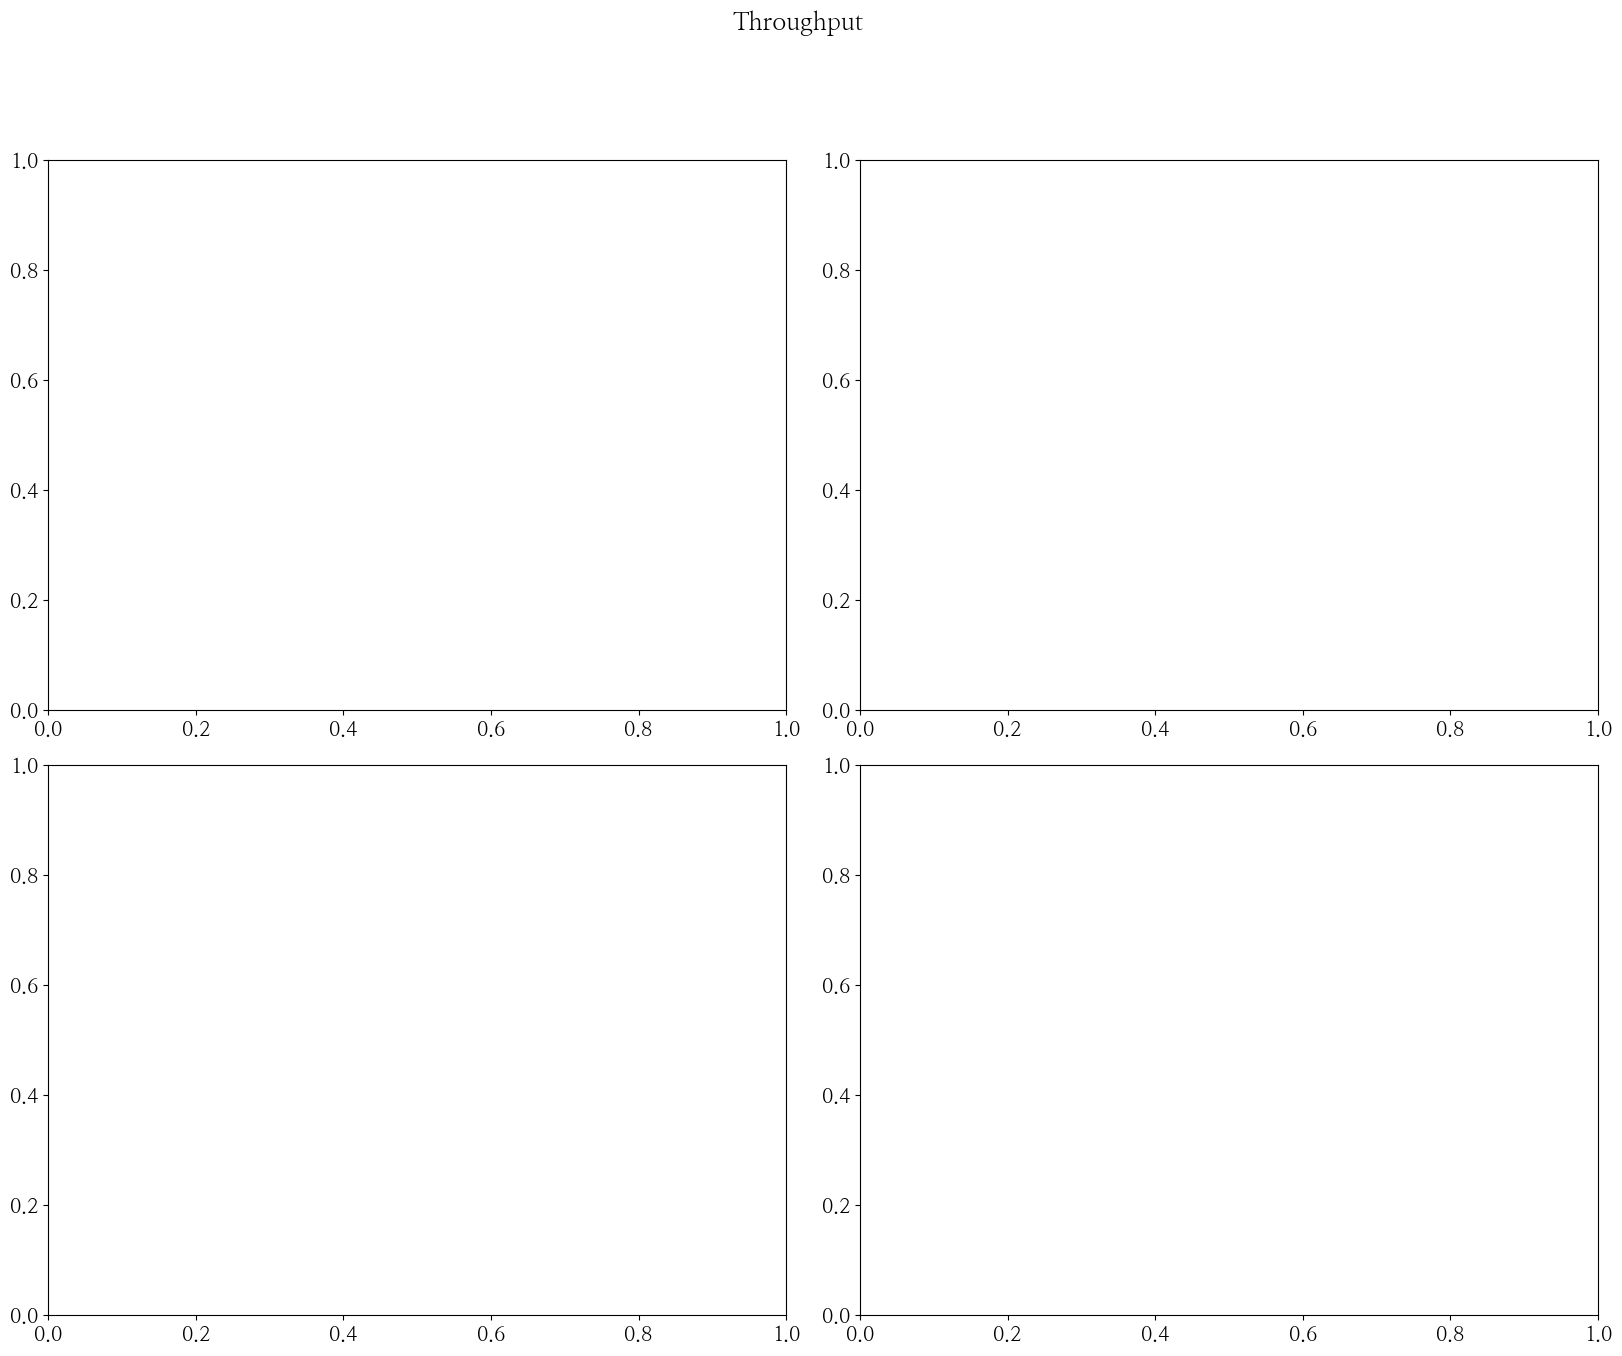

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) # 2 x 2 에 해당하는 plot 들을 생성
# 격자 크기 설정
fig.set_size_inches((20, 15))
# 격자 여백 설절
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Throughput')

bar = axs[0, 0].bar(x_label, sum_stow_by_timerange, label='Actual')
axs[0, 0].set_title('Actual stow trend') # 제목
axs[0, 0].set_ylim(0,50)
axs[0, 0].legend() # 범례
axs[0, 0].set(xlabel='Timerange', ylabel='plt') #
axs[0, 0].set_facecolor('lightyellow') # 전경
axs[0, 0].grid(linestyle='--', linewidth=0.5)
plt.show()
